# Introduction

This notebook explores the potential to calculate wind speed and direction on the ground from a vehicle in flight.

The **primary application** focus is to gather magnitude and direction of the wind on the ground from a fixed wing aircraft preparing to land.

Generally it is wise to both take off and land facing into the wind. This minimizes the amount of kinetic energy one carries relative to the ground. 

$$Kinetic Energy =\frac{1}{2}mass * velocity^{2}$$

The less energy, the safer aircraft operations close to the ground are. In addition to reduced kinetic energy, it also allows for shorter takeoff and landing distances. Which can be incredibly useful when operating out of unimproved runways or in the backcountry.

# Theory

Determining the wind direction and speed on the ground while in the air amounts to separating:
1. Air moving relative to the aircraft
2. Air moving relative to the ground

This is tricky because the only measurable air while in flight, is the air relative to the aircraft. There are other quantites to measure though, like position, that may be useful to compare to measurements of the air to try and understand the wind velocity on the ground.


### Airspeed Discussion

Airspeed measured at the aircraft is called IAS or indicated airspeed. This speed represents the dynamic pressure, Or the difference between total pressure and static pressure. Read about it here: https://en.wikipedia.org/wiki/Indicated_airspeed

Indicated airspeed is not the same as true airspeed. 

I will not be able to get a true airspeed reading using only dynamic pressure. Fortunately, the application of a pilot trying to land into the wind is perfect for using indicated airspeed as opposed to true airspeed. The benefit of indicated airspeed is that it correlates directly with the impact of the wind on the aircraft. An aircraft may stall or handle differently at a given true airspeed depending on air density, but an aircraft always handles and stalls the same way at a given indicated airspeed.

### Initial Idea

My first thought is to measure the dynamic pressure (indicated airspeed) via static pressure and total pressure measurements at the aircraft along with ground speed and direction measured using GPS. Taking the difference between the ground and airspeeds in every direction measured may provide enough information to calculate the wind speed and direction.

As a proof of concept, I will simulate a dataset gathered from the aircraft in a 360 degree, level altitude, coordinated turn at a constant airspeed. Then begin evaluating a method to compute wind speed and direction from that dataset.

The resulting dataset should have 3 attributes that I plan to measure from an aircraft: GPS Speed, GPS Track, and Airspeed.

I need to be able to simulate the situation of the wind blowing on the aircraft during its 360 degree turn to calculate accurate GPS track and speed. To do so, I will need to compute the impact of the wind velocity and airspeed on the GPS speed and track at each sample. Again, assuming the aircraft is flying a 360 degree, level altitude, coordinated, constant airspeed turn. (Visualized Below)

![title](visualization.png)

The GPS track and speed at each sample will be a function of the airspeed, and the wind velocity. Therefore, airspeed, wind speed, and wind direction will all need to be defined before creating the simulated dataset.

In [506]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

# set a constant airspeed
airspeed = 65

# set a wind speed
windspeed = 17

# set a wind direction
winddir = 215

The aircraft will go through all 360 degrees of direction. For simplicity, I will assume a sample is taken for every 10 degrees turned. I will also need to create a column to contain the aircrafts heading, while this column is not a part of the final dataset, I will use it to generate that dataset.

In [507]:
# instantiate a dataframe to hold the data
data = pd.DataFrame()

# num samples
samples = 360

# set the airspeed for every sample
data['airspeed'] = [airspeed]*samples

# set the aircraft heading for every sample
data['heading'] = np.arange(0,360,360/samples)

# preview the top of the data
data.head()

,airspeed,heading
0,65,0.0
1,65,1.0
2,65,2.0
3,65,3.0
4,65,4.0


Now there is a dataframe containing 36 simulated samples of airspeed during the 360 degree turn. I need to create columns to represet ground speed and ground direction. Ground speed is found by evaluating the magnitude of the sum of airspeed and direction with wind speed and direction. I'll break up ground velocity into eastward and northward components respectively first, then compute the magnitude and direction from that.

In [508]:
# calculate East and North components of the ground velocity
data['eastward'] = np.round(data['airspeed'] * np.sin(data['heading'] * math.pi / 180) + \
                            windspeed * np.sin(winddir * math.pi / 180),4)
data['northward'] = np.round(data['airspeed'] * np.cos(data['heading'] * math.pi / 180) + \
                             windspeed * np.cos(winddir * math.pi / 180),4)

# converting to magnitude and direction
data['groundspeed'] = np.round(np.sqrt(data['eastward']**2 + data['northward']**2),4)
data['grounddir'] = np.round(np.degrees(np.arctan2(data['eastward'], data['northward'])),4)

# confirming the data looks as expected
data

,airspeed,heading,eastward,northward,groundspeed,grounddir
0,65,0.0,-9.7508,51.0744,51.9969,-10.8085
1,65,1.0,-8.6164,51.0645,51.7863,-9.5776
2,65,2.0,-7.4823,51.0348,51.5804,-8.3408
3,65,3.0,-6.3490,50.9853,51.3791,-7.0983
4,65,4.0,-5.2166,50.9161,51.1826,-5.8498
5,65,5.0,-4.0857,50.8271,50.9910,-4.5958
6,65,6.0,-2.9564,50.7183,50.8044,-3.3360
7,65,7.0,-1.8293,50.5899,50.6230,-2.0709
8,65,8.0,-0.7045,50.4418,50.4467,-0.8002
9,65,9.0,0.4174,50.2742,50.2759,0.4757


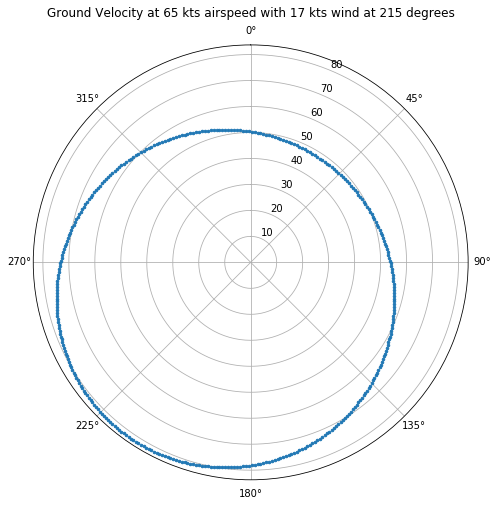

In [509]:
plt.figure(figsize=(8,8))
plt.polar(np.radians(data['grounddir']), data['groundspeed'], ls = 'none', marker = '.', ms=5)
plt.title('Ground Velocity at ' + str(airspeed) + ' kts airspeed with ' + str(windspeed) + ' kts wind at ' \
          + str(winddir) + ' degrees');
axes = plt.gca()
axes.set_theta_offset(np.pi/2)
axes.set_theta_direction(-1)
#plt.ylim(airspeed-20,airspeed+20)
plt.show()

I'll need to filter the columns in the dataset to contain only the data I will capture while flying. That means removing heading, as eastward and northward components of the ground velocity are computed from the ground speed and direction.

In [510]:
simdata = data.drop('heading', axis=1)
simdata.head()

,airspeed,eastward,northward,groundspeed,grounddir
0,65,-9.7508,51.0744,51.9969,-10.8085
1,65,-8.6164,51.0645,51.7863,-9.5776
2,65,-7.4823,51.0348,51.5804,-8.3408
3,65,-6.3490,50.9853,51.3791,-7.0983
4,65,-5.2166,50.9161,51.1826,-5.8498


From this data, I need to be able to come up with a calculation of the wind speed and direction.

In [511]:
simdata['gnd-ias'] = simdata['groundspeed'] - simdata['airspeed']
simdata.head()

,airspeed,eastward,northward,groundspeed,grounddir,gnd-ias
0,65,-9.7508,51.0744,51.9969,-10.8085,-13.0031
1,65,-8.6164,51.0645,51.7863,-9.5776,-13.2137
2,65,-7.4823,51.0348,51.5804,-8.3408,-13.4196
3,65,-6.3490,50.9853,51.3791,-7.0983,-13.6209
4,65,-5.2166,50.9161,51.1826,-5.8498,-13.8174


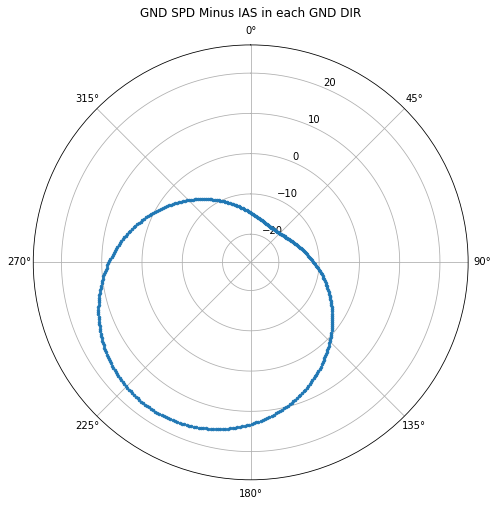

In [512]:
fig = plt.figure(figsize=(8,8))
plt.polar(np.radians(simdata['grounddir']), simdata['gnd-ias'], ls = 'none', marker = '.', ms=5)
plt.title('GND SPD Minus IAS in each GND DIR');
plt.ylim(np.min(simdata['gnd-ias'])-10,np.max(simdata['gnd-ias'])+10)
axes = plt.gca()
axes.set_theta_offset(np.pi/2)
axes.set_theta_direction(-1)
plt.show()

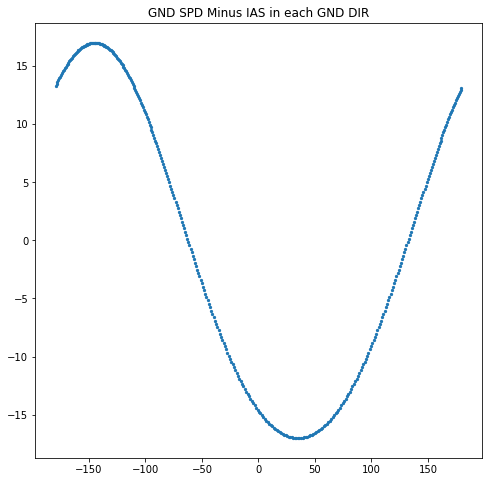

In [513]:
fig = plt.figure(figsize=(8,8))
plt.title('GND SPD Minus IAS in each GND DIR');
plt.scatter(simdata['grounddir'],simdata['gnd-ias'],s=5)
plt.show()

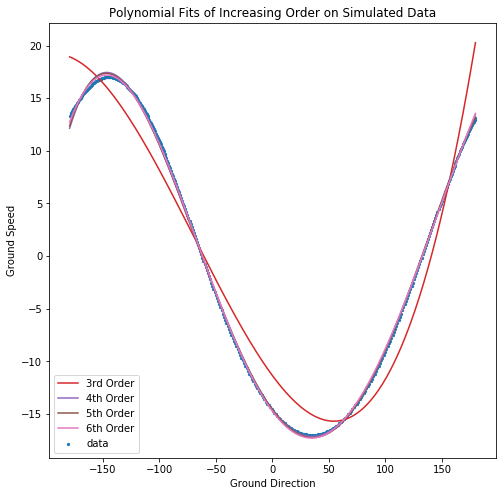

In [514]:
import numpy.polynomial.polynomial as poly

simdata.sort_values('grounddir', inplace=True)

x = simdata['grounddir']
y = simdata['gnd-ias']

# instantiate a dictionary to hold residuals for each fit
sr = pd.DataFrame()

fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, s=5)
for order in np.arange(3,7,1):
    coefs = poly.polyfit(x, y, order)
    ffit = poly.polyval(x, coefs)
    plt.plot(x, ffit, color='C'+str(order))
    
    sr[order] = (ffit-y)**2
    
plt.legend(['3rd Order', '4th Order', '5th Order', '6th Order','data'])
plt.xlabel('Ground Direction')
plt.ylabel('Ground Speed')
plt.title('Polynomial Fits of Increasing Order on Simulated Data')
plt.show()

In [515]:
import scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters \
    "amp", "omega", "phase", "offset", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    w = 2*np.pi*1/360
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 0., guess_offset])
    def sinfunc(t, A, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, \
            "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

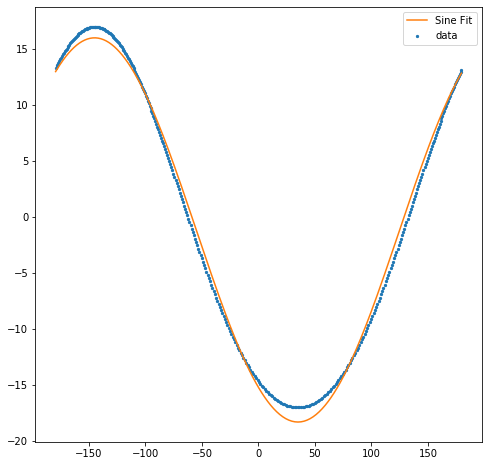

In [516]:
# fit a sine function to the data
res = fit_sin(simdata['grounddir'], simdata['gnd-ias'])

# calculate the squared residuals
sr['Sine'] = (res['fitfunc'](simdata['grounddir']) - simdata['gnd-ias'])**2 

plt.figure(figsize=[8,8])
plt.scatter(simdata['grounddir'], simdata['gnd-ias'], label='data', s=5)
plt.plot(simdata['grounddir'], res['fitfunc'](simdata['grounddir']), color='C1', label='Sine Fit')
plt.legend()
plt.show()

In [517]:
# retrieve the sum of squared residuals for all fits
np.sum(sr)

3       2354.623971
4         20.659904
5         18.476704
6         13.272908
Sine     226.246616
dtype: float64

The sum of squared error of the 6th order polynomial is much lower than the sine fit, however the sine fit may be more generalized to the problem when real data comes in with bias, variance, and noise. I can simulate data with normally distributed noise.

In [518]:
# set sigma for normal distribution
sigma = 5

# generate normally distributed samples
noise = sigma * np.random.randn(len(simdata))

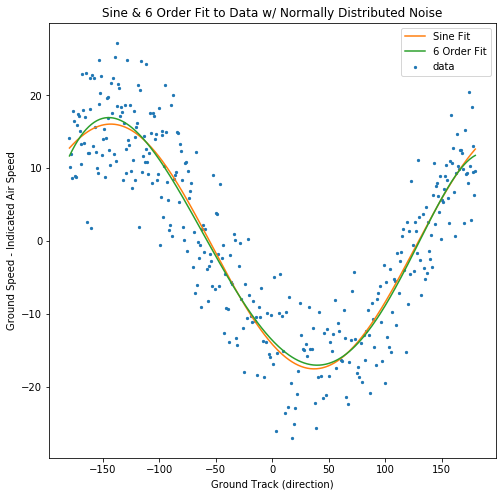

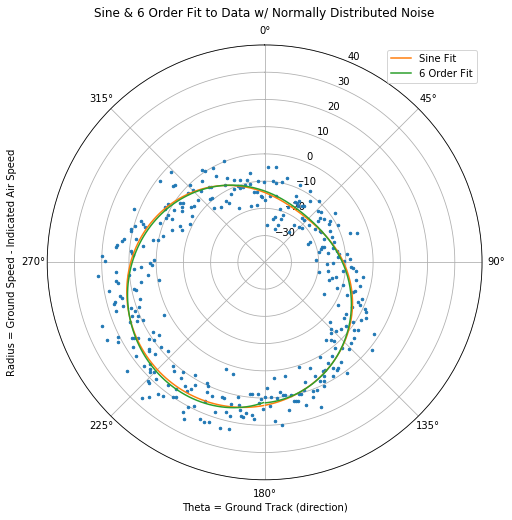

In [519]:
# create a dataframe column for gnd-ias with noise
simdata['gnd-ias_noisy'] = simdata['gnd-ias'] + noise 

x = simdata['grounddir']
y = simdata['gnd-ias_noisy']

# fit sine and polynomial to noisy data
order = 6
res = fit_sin(x, y)
coefs = poly.polyfit(x, y, order)
ffit = poly.polyval(x, coefs)

# calculate the squared residuals
srn = pd.DataFrame()
srn['Sine_noisy'] = (res['fitfunc'](x) - y)**2 
srn['6_noisy'] = (ffit - y)**2 

# plot cartesian
plt.figure(figsize=[8,8])
plt.scatter(x, y, label='data', s=5)
plt.plot(x, res['fitfunc'](x), color='C1', label='Sine Fit')
plt.plot(x, ffit, color = 'C2', label=str(order)+' Order Fit')
plt.legend()
plt.title('Sine & '+str(order)+' Order Fit to Data w/ Normally Distributed Noise')
plt.ylabel('Ground Speed - Indicated Air Speed')
plt.xlabel('Ground Track (direction)')
plt.show()

# plot polar
plt.figure(figsize=[8,8])
plt.polar(np.radians(x), y, ls = 'none', marker = '.', ms=5)
plt.polar(np.radians(x), res['fitfunc'](x), color='C1', label='Sine Fit')
plt.plot(np.radians(x), ffit, color = 'C2', label=str(order)+' Order Fit')
plt.legend()
plt.title('Sine & '+str(order)+' Order Fit to Data w/ Normally Distributed Noise')
plt.ylabel('Radius = Ground Speed - Indicated Air Speed', labelpad=30)
plt.xlabel('Theta = Ground Track (direction)')
axes = plt.gca()
axes.set_theta_offset(np.pi/2)
axes.set_theta_direction(-1)
plt.ylim(np.min(y)-np.std(y),np.max(y)+np.std(y))
plt.show()


In [524]:
# print the sum of squared residuals for the two fits
np.sum(srn)

Sine_noisy    9879.835208
6_noisy       9784.814889
dtype: float64

In [520]:
# Add the sine prediction to the dataframe
simdata['sine_pred'] = res['fitfunc'](x)

In [526]:
pred_speed = np.mean([abs(np.min(res['fitfunc'](x))), abs(np.max(res['fitfunc'](x)))])
pred_dir = simdata[simdata['sine_pred'] == np.max(simdata['sine_pred'])]['grounddir']
if pred_dir.values[0] < 0:
    pred_dir = pred_dir.values[0] + 360
print('Estimated Wind Speed:',np.round(pred_speed,0),'Estimated Direction:',np.round(pred_dir,0))
print('True Wind Speed:',windspeed,' True Direction:', winddir)

Estimated Wind Speed: 17.0 Estimated Direction: 217.0
True Wind Speed: 17  True Direction: 215
